In [1]:
import numpy as np
from scipy.special import factorial
import scipy.sparse as sparse
import scipy.sparse.linalg as spla
import math
import matplotlib.pyplot as plt
from collections import deque


class UniformPeriodicGrid:

    def __init__(self, N, length):
        self.values = np.linspace(0, length, N, endpoint=False)
        self.dx = self.values[1] - self.values[0]
        self.length = length
        self.N = N


class NonUniformPeriodicGrid:

    def __init__(self, values, length):
        self.values = values
        self.length = length
        self.N = len(values)


class DifferenceUniformGrid:

    def __init__(self, derivative_order, convergence_order, grid, stencil_type='centered'):

        self.derivative_order = derivative_order
        self.convergence_order = convergence_order
        self.stencil_type = stencil_type
        #print("Check1")
        #Goal: Return D
        #initial parameters
        N=grid.N
        h=grid.dx
        ddx=derivative_order
        convE=convergence_order

        #print("Check2")
        #Create R matrix
        convE=2*math.ceil(convE/2)
        d=2*math.floor((ddx+convE-1)/2)+1
        mid=math.floor(d/2)

        R=np.zeros((d,d))
        r0=np.ones(d)
        r=h*np.arange(start=-(d-1)/2, stop=(d+1)/2, step=1)

        R[0]=r0
        i=1
        while i<d:
            R[i]=r**i
            i+=1
            
        #print("Check3")
        # Create k vector
        k=np.zeros(d)
        k[ddx]=1

        #Solve for coefficients, a
        a=math.factorial(ddx)*np.linalg.inv(R)@k
        
        #print("Check4")
        #Arrange coefficients in a sparse, derivative matrix: D
        lowerTri=np.arange(start=-N+1, stop=-N+mid+1, step=1)
        upperTri=np.arange(start=N-mid, stop=N, step=1)
        mainDiag=np.arange(start=-mid, stop=mid+1, step=1)

        #print("Main Diag: ", mainDiag)
        #print("a: ", a)
        Dmd = sparse.diags(a, mainDiag, shape=(N, N))
        DuT = sparse.diags(a[:mid], upperTri, shape=(N, N))
        DlT = sparse.diags(a[mid+1:], lowerTri, shape=(N, N))
        D = Dmd + DuT + DlT
        self.matrix = D
        pass

    def __matmul__(self, other):
        return self.matrix @ other


class DifferenceNonUniformGrid:

    def __init__(self, derivative_order, convergence_order, Grid, stencil_type='centered'):

        self.derivative_order = derivative_order
        self.convergence_order = convergence_order
        self.stencil_type = stencil_type
        self.grid = Grid
        
        grid=Grid.values
        length=Grid.length
        N=Grid.N
        ddx=derivative_order
        convE=convergence_order
        
        #Create R matrix
        convE=2*math.ceil(convE/2)
        d=2*math.floor((ddx+convE-1)/2)+1
        mid=math.floor(d/2)

        # Create k vector
        k=np.zeros(d)
        k[ddx]=math.factorial(ddx)

        #Begin iteration to construct D by individual stencil
        D = sparse.csr_matrix(np.zeros((N,N)))
        i=0
        while i<N: 
            R=np.zeros((d,d))
            r0=np.ones(d)
            r=np.roll(grid, mid-i)[0:d]-grid[i]*np.ones(d)
            if i<mid:
                j=0
                while j<mid-i:
                    r[j]=r[j]-length
                    j+=1
            elif i>N-mid-1:
                j=-1 
                while j>(N-i)-mid-2:
                    r[j]=r[j]+length
                    j-=1        

            R[0]=r0
            j=1
            while j<d:
                R[j]=r**j
                j+=1
        
            Rinv=np.linalg.inv(R)

            #Solve for coefficients, a
            a=Rinv@k

            #Construct D row i, col j
            a_0s=np.concatenate((a,np.zeros(N-d)))
            a_0s_rolled=np.roll(a_0s, i-mid)
            D[i]=a_0s_rolled

            i+=1
        self.matrix = D
        pass

    def __matmul__(self, other):
        return self.matrix @ other
    
    
class Difference:

    def __matmul__(self, other):
        return self.matrix @ other


class ForwardFiniteDifference(Difference):

    def __init__(self, grid):
        h = grid.dx
        N = grid.N
        j = [0, 1]
        diags = np.array([-1/h, 1/h])
        matrix = sparse.diags(diags, offsets=j, shape=[N,N])
        matrix = matrix.tocsr()
        matrix[-1, 0] = 1/h
        self.matrix = matrix


class CenteredFiniteDifference(Difference):

    def __init__(self, grid):
        h = grid.dx
        N = grid.N
        j = [-1, 0, 1]
        diags = np.array([-1/(2*h), 0, 1/(2*h)])
        matrix = sparse.diags(diags, offsets=j, shape=[N,N])
        matrix = matrix.tocsr()
        matrix[-1, 0] = 1/(2*h)
        matrix[0, -1] = -1/(2*h)
        self.matrix = matrix


class CenteredFiniteSecondDifference(Difference):

    def __init__(self, grid):
        h = grid.dx
        N = grid.N
        j = [-1, 0, 1]
        diags = np.array([1/h**2, -2/h**2, 1/h**2])
        matrix = sparse.diags(diags, offsets=j, shape=[N,N])
        matrix = matrix.tocsr()
        matrix[-1, 0] = 1/h**2
        matrix[0, -1] = 1/h**2
        self.matrix = matrix


class CenteredFiniteDifference4(Difference):

    def __init__(self, grid):
        h = grid.dx
        N = grid.N
        j = [-2, -1, 0, 1, 2]
        diags = np.array([1, -8, 0, 8, -1])/(12*h)
        matrix = sparse.diags(diags, offsets=j, shape=[N,N])
        matrix = matrix.tocsr()
        matrix[-2, 0] = -1/(12*h)
        matrix[-1, 0] = 8/(12*h)
        matrix[-1, 1] = -1/(12*h)

        matrix[0, -2] = 1/(12*h)
        matrix[0, -1] = -8/(12*h)
        matrix[1, -1] = 1/(12*h)
        self.matrix = matrix


In [10]:
class Timestepper:

    def __init__(self, u, f):
        self.t = 0
        self.iter = 0
        self.u = u
        self.func = f
        self.dt = None

    def step(self, dt):
        self.u = self._step(dt)
        self.t += dt
        self.iter += 1
        
    def evolve(self, dt, time):
        while self.t < time - 1e-8:
            self.step(dt)


class ForwardEuler(Timestepper):

    def _step(self, dt):
        return self.u + dt*self.func(self.u)


class LaxFriedrichs(Timestepper):

    def __init__(self, u, f):
        super().__init__(u, f)
        N = len(u)
        A = sparse.diags([1/2, 1/2], offsets=[-1, 1], shape=[N, N])
        A = A.tocsr()
        A[0, -1] = 1/2
        A[-1, 0] = 1/2
        self.A = A

    def _step(self, dt):
        return self.A @ self.u + dt*self.func(self.u)


class Leapfrog(Timestepper):

    def _step(self, dt):
        if self.iter == 0:
            self.u_old = np.copy(self.u)
            return self.u + dt*self.func(self.u)
        else:
            u_temp = self.u_old + 2*dt*self.func(self.u)
            self.u_old = np.copy(self.u)
            return u_temp


class LaxWendroff(Timestepper):

    def __init__(self, u, func1, func2):
        self.t = 0
        self.iter = 0
        self.u = u
        self.f1 = func1
        self.f2 = func2

    def _step(self, dt):
        return self.u + dt*self.f1(self.u) + dt**2/2*self.f2(self.u)


class Multistage(Timestepper):

    def __init__(self, u, f, stages, a, b):
        super().__init__(u, f)
        self.stages = stages
        self.a = a
        self.b = b

        self.u_list = []
        self.K_list = []
        for i in range(self.stages):
            self.u_list.append(np.copy(u))
            self.K_list.append(np.copy(u))

    def _step(self, dt):
        u = self.u
        u_list = self.u_list
        K_list = self.K_list
        stages = self.stages

        np.copyto(u_list[0], u)
        for i in range(1, stages):
            K_list[i-1] = self.func(u_list[i-1])

            np.copyto(u_list[i], u)
            # this loop is slow -- should make K_list a 2D array
            for j in range(i):
                u_list[i] += self.a[i, j]*dt*K_list[j]

        K_list[-1] = self.func(u_list[-1])

        # this loop is slow -- should make K_list a 2D array
        for i in range(stages):
            u += self.b[i]*dt*K_list[i]

        return u


class AdamsBashforth(Timestepper):

    def __init__(self, u, L_op, steps, dt):
        super().__init__(u, L_op)
        self.steps = steps
        self.dt = dt
        self.f_list = deque()
        for i in range(self.steps):
            self.f_list.append(np.copy(u))

    def _step(self, dt):
        f_list = self.f_list
        f_list.rotate()
        f_list[0] = self.func(self.u)
        if self.iter < self.steps:
            coeffs = self._coeffs(self.iter+1)
        else:
            coeffs = self._coeffs(self.steps)

        for i, coeff in enumerate(coeffs):
            self.u += self.dt*coeff*self.f_list[i].data
        return self.u

    def _coeffs(self, num):

        i = (1 + np.arange(num))[None, :]
        j = (1 + np.arange(num))[:, None]
        S = (-i)**(j-1)/factorial(j-1)

        b = (-1)**(j+1)/factorial(j)

        a = np.linalg.solve(S, b)
        return a


class BackwardEuler(Timestepper):

    def __init__(self, u, L):
        super().__init__(u, L)
        N = len(u)
        self.I = sparse.eye(N, N)

    def _step(self, dt):
        if dt != self.dt:
            self.LHS = self.I - dt*self.func.matrix
            self.LU = spla.splu(self.LHS.tocsc(), permc_spec='NATURAL')
        self.dt = dt
        return self.LU.solve(self.u)


class CrankNicolson(Timestepper):

    def __init__(self, u, L_op):
        super().__init__(u, L_op)
        N = len(u)
        self.I = sparse.eye(N, N)

    def _step(self, dt):
        if dt != self.dt:
            self.LHS = self.I - dt/2*self.func.matrix
            self.RHS = self.I + dt/2*self.func.matrix
            self.LU = spla.splu(self.LHS.tocsc(), permc_spec='NATURAL')
        self.dt = dt
        return self.LU.solve(self.RHS @ self.u)

class BackwardDifferentiationFormula(Timestepper):
    def __init__(self, u, L_op, steps):
        super().__init__(u, L_op)
        self.L_op = L_op
        self.steps = steps
        self.past = [None]*(steps+1)
        self.dts = np.zeros(steps+1)
        
    def _step(self, dt):
        #Account for initial condition where not enough previous steps exist
        if (self.iter + 1) < self.steps:
            s = self.iter + 1
        else:
            s = self.steps
        
        #Fix U_olds and create array of delta ts for previous steps
        for i in range(1, len(self.past)):
            self.past[len(self.past)-i] = self.past[len(self.past)-i-1]
            self.dts[len(self.dts)-i] = self.dts[len(self.dts)-i-1]
        self.past[0] = np.zeros(len(self.u))
        self.past[1] = self.u
        self.dts[0] = 0
        self.dts[1] = dt
        
            
        a = np.zeros(s+1)
        deets = np.zeros(s+1)
        deets[1] = 1
        
        M = np.zeros(shape=(s+1,s+1))
        for i in range(0,s+1):
            temp_dt = 0
            for j in range(0,s+1):
                temp_dt += self.dts[j]
                M[i,j] = (temp_dt**(i))

        a = np.linalg.inv(M) @ deets
        
        sums = np.zeros(len(self.u))
        for i in range(1,s+1):
            sums += a[i]*self.past[i]
        
        newmat = - self.L_op.matrix - a[0]*np.identity(len(self.u))
        sol = np.linalg.inv(newmat) @ sums
        sol = np.array(sol)
        sol.resize(len(self.u))
        return sol
    
class BackwardDifferentiationFormulaOld(Timestepper):

    def __init__(self, u, L_op, steps):
        super().__init__(u, L_op)
        N = len(u)
        self.trail = steps
        self.past = np.zeros((steps+1, N))
        self.past[0] = u
        self.pastdt = np.zeros(steps)
        self.I = sparse.eye(N, N)
        self.BigStep = 0
        self.L_op=L_op


    def _step(self, dt):
        BigStep = self.BigStep
        N=len(self.u)
        pastdt = self.pastdt
        self.pastdt = np.roll(pastdt, 1)
        self.pastdt[0]=dt
        pastdt = self.pastdt
        steps = self.trail
        Dt = np.zeros(steps)
        i=0
        while i<steps:
            Dt[i]=np.sum(pastdt[:i+1])
            i+=1
        #print("Iter: ", self.iter)
        #print("u = ", self.past[0])
        #print("u_-1 = ", self.past[1])
        #print("past steps = ", self.past[1:,:])
        #print(pastdt)
        #print(Dt)
        if self.iter == 0:
            self.LHS = self.I - dt*self.L_op.matrix
            self.LU = spla.splu(self.LHS.tocsc(), permc_spec='NATURAL')
            Sol = self.LU.solve(self.u)
            
            
        #Find coefficients for solve step
        elif pastdt[0] != pastdt[1] or BigStep < steps:
            if pastdt[0] != pastdt[1]:
                self.BigStep=0
            else:
                self.BigStep+=1
            Msize = min(self.iter, steps)
            #print(Msize)
            M = np.zeros((Msize,Msize))
            M[0] = np.ones(Msize)
            j=1
            while j<Msize:
                k=0
                while k<Msize:
                    #print("M = ", M)
                    #print("Msize = ", Msize)
                    #print("j = ", j)
                    #print("k = ", k)
                    M[j,k]=((Dt[k])**j)
                    k+=1
                j+=1
            Minv = np.linalg.inv(M)
            w = Minv[:,0]
            #print("w = ", w)
            a = -w/Dt[:Msize]
            print(a)
            aNext = np.sum(a)
            #print("a = ", a)
            self.LHS = self.L_op.matrix + aNext * self.I 
            self.LU = spla.splu(self.LHS.tocsc(), permc_spec='NATURAL')
            #print(a@self.past[1:len(a)+1,:])
            Sol = self.LU.solve(a @ self.past[1:len(a)+1, :])
            self.a = a
            self.aNext = aNext
        else:
            self.LHS = self.L_op.matrix + self.aNext * self.I 
            self.LU = spla.splu(self.LHS.tocsc(), permc_spec='NATURAL')
            Sol = self.LU.solve(self.a @ self.past[1:len(self.a)+1, :])
        self.past = np.roll(self.past, 1, axis=0) 
        self.past[0] = Sol
        return Sol


class StateVector:
    
    def __init__(self, variables):
        var0 = variables[0]
        self.N = len(var0)
        size = self.N*len(variables)
        self.data = np.zeros(size)
        self.variables = variables
        self.gather()

    def gather(self):
        for i, var in enumerate(self.variables):
            np.copyto(self.data[i*self.N:(i+1)*self.N], var)

    def scatter(self):
        for i, var in enumerate(self.variables):
            np.copyto(var, self.data[i*self.N:(i+1)*self.N])


class IMEXTimestepper:

    def __init__(self, eq_set):
        self.t = 0
        self.iter = 0
        self.X = eq_set.X
        self.M = eq_set.M
        self.L = eq_set.L
        self.F = eq_set.F
        self.dt = None

    def evolve(self, dt, time):
        while self.t < time - 1e-8:
            self.step(dt)

    def step(self, dt):
        self.X.data = self._step(dt)
        self.X.scatter()
        self.t += dt
        self.iter += 1


class Euler(IMEXTimestepper):

    def _step(self, dt):
        if dt != self.dt:
            LHS = self.M + dt*self.L
            self.LU = spla.splu(LHS.tocsc(), permc_spec='NATURAL')
        self.dt = dt
        
        RHS = self.M @ self.X.data + dt*self.F(self.X)
        return self.LU.solve(RHS)


class CNAB(IMEXTimestepper):

    def _step(self, dt):
        if self.iter == 0:
            # Euler
            LHS = self.M + dt*self.L
            LU = spla.splu(LHS.tocsc(), permc_spec='NATURAL')

            self.FX = self.F(self.X)
            RHS = self.M @ self.X.data + dt*self.FX
            self.FX_old = self.FX
            return LU.solve(RHS)
        else:
            if dt != self.dt:
                LHS = self.M + dt/2*self.L
                self.LU = spla.splu(LHS.tocsc(), permc_spec='NATURAL')
            self.dt = dt

            self.FX = self.F(self.X)
            RHS = self.M @ self.X.data - 0.5*dt*self.L @ self.X.data + 3/2*dt*self.FX - 1/2*dt*self.FX_old
            self.FX_old = self.FX
            return self.LU.solve(RHS)


class BDFExtrapolate(IMEXTimestepper):

    def __init__(self, eq_set, steps):
        super().__init__(eq_set)
        self.steps = steps
        pass

    def _step(self, dt):
        
        
        #LHS= self.M @ (np.product(a, self.X)) + self.L @ 
        #RHS=
        #self.LU = spla.splu(LHS.tocsc(),permc_spec='NATURAL')
        return self.LU.solve(RHS)
        pass
    
def plot_2D(matrix, title='FD matrix'):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.title(title)
    plt.tight_layout()

[-8.33511205e-15  1.06103295e+01 -1.32629119e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

C:\Users\Owner\AppData\Local\Temp/ipykernel_9772/1972852608.py:397: RuntimeWarning: divide by zero encountered in log10
  matrix_mag = np.log10(np.abs(matrix))


NameError: name 'error_est' is not defined

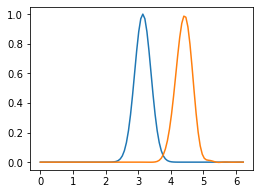

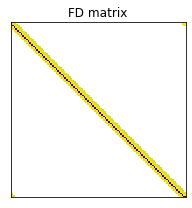

In [12]:
test=0
resolution_list = [100, 100, 200, 400]
resolution = resolution_list[test]
spatial_order=4
error_BDF2_wave = {(100,2):0.5, (200,2):0.2, (400,2):0.06, (100,4):0.08, (200,4):0.008, (400,4):0.002}

grid = UniformPeriodicGrid(resolution, 2*np.pi)
x = grid.values

IC = np.exp(-(x-np.pi)**2*8)
target = np.exp(-(-x-np.pi-2*np.pi*0.2)**2*8)

d = DifferenceUniformGrid(1, spatial_order, grid)
ts = BackwardDifferentiationFormula(IC, d, 2)

alpha = 0.1
num_periods = 1.8
ts.evolve(alpha*grid.dx, 2*np.pi*num_periods)

error = np.max(np.abs( ts.u - target))
#error_est = error_BDF2_wave[(resolution,spatial_order)]

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, target)
p, = plt.plot(x, IC)
p, = plt.plot(x, ts.u)

plot_2D(d.matrix.A)
print(d.matrix.A[0])
print(error < error_est)


In [ ]:

#Runs okay
steps=2
if steps<1:
    steps=1
r=np.zeros((steps,steps))
w=np.zeros((steps,steps))
j=1
while j<=steps:
    b=np.zeros((j,j))
    b[0]=np.ones(j)
    i=1
    while i<j:
        b[i]=(-1)**i/math.factorial(i)*np.arange(j)**i
        i+=1
    r[j-1][:j]=scipy.special.factorial(np.arange(1,j+1))**(-1)
    w[j-1][:j]=np.linalg.inv(b)@r[j-1][:j]
    j+=1
print("w: ", w)


#Needs checked
iters=0
grid = finite.UniformPeriodicGrid(200, 2*np.pi)
dt = 0.1*grid.dx
x = grid.values
u0 = np.exp(-(x-np.pi)**2*8)
u0prime = -16*(x-np.pi)*np.exp(-(x-np.pi)**2*8)
u=np.zeros((steps,len(u0)))
u[0]=u0

target = np.exp(-(u0-np.pi-2*np.pi*0.2)**2*8)
d = finite.DifferenceUniformGrid(1, 28, grid)
#plot_2D(d.matrix.A)
func = lambda u: d @ u

###Start do NOT include####
TimeSteps=8100
while iters<=TimeSteps:
###End ###
    BONUS=np.zeros(200)
    if iters>=steps:
        i=0
        while i<steps:
            #print(BONUS[80],"+",w[steps-1,i],"*",func(u[i])[80],"=")
            BONUS=BONUS+w[steps-1,i]*func(u[i])
            #print(BONUS[80])
            i+=1
    else:
        i=0
        while i<=iters:
            #print(BONUS[80],"+",w[iters,i],"*",func(u[i])[80],"=")
            BONUS=BONUS+w[iters,i]*func(u[i])
            #print(BONUS[80])
            i+=1
    u=np.roll(u,1, axis=0)
    if steps<=1:
        u[0]=u[0]+dt*BONUS
    else:
        u[0]=u[1]+dt*BONUS
    #print("u=", u[0,80], "=", u[1,80], "+", dt, "*", BONUS[80])
    #print("out: ", iters)
    ###BEgin###
    iters+=1
    ###End###
#print(u)
fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, func(u[0]))
p, = plt.plot(x, u0prime)
#p, = plt.plot(x,u[steps-2])
#p, = plt.plot(x,u[1])
#p, = plt.plot(x,u0prime-func(u[0]))

#plt.ylim([-0.1, 1.1])
fig.canvas.draw()
#p.set_ydata(u[steps-1])
fig.canvas.draw()

In [248]:
q=np.array([[3, 2], [4, 1], [5, 0]])
q=np.roll(q,1,axis=0)
print(q)
print(np.array([-1, 2])@q[1:2+1, :])

[[5 0]
 [3 2]
 [4 1]]
[5 0]


In [85]:
q[:,:1]

array([[3],
       [4],
       [5]])

In [193]:
print(np.array([1, 4])*np.array([5, 6]))

[ 5 24]


In [289]:
delta_ts = np.zeros(steps+1)
dt=0.1
delta_ts[1] = dt
s=2

aas = np.zeros(s+1)
dts = np.zeros(s+1)
dts[1] = 1
mat = np.zeros(shape=(s+1,s+1))
for i in range(0,s+1):
    temp_dt = 0
    for j in range(0,s+1):
        temp_dt += delta_ts[j]
        mat[i,j] = (temp_dt**(i))

aas = np.linalg.inv(mat) @ dts
print(mat)

[[1.   1.   1.  ]
 [0.   0.1  0.1 ]
 [0.   0.01 0.01]]
